# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from paths_and_parameters import *
path_phases_check = path_figures + 'phases_check/'

paths_to_create_delete = [subfolder_output, path_figures, path_phases_check, path_database_exp, path_calibrations]

distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read and show photo of scanned section

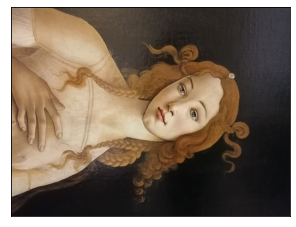

In [4]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    img_photo = Image.open(filename)
    fig, ax = subplots(figsize = (5, 5))
    ax.imshow(img_photo.transpose(1).rotate(90 * steps_rotation_photo, expand = True))
    ax.set_yticks([])
    ax.set_xticks([])
    show()

# Read phase database

In [5]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [12]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MuseiRealiVenere/VenereXRD/Acquisition0001/xrd.h5

Shape of data
-------------
x: 140, y: 90, channels: 1280

Initial calibration
-------------------
a = -1189.4, s = 2446.9, beta = 42.052
Theta range: [16.12723999556657, 44.17163458000753]


### Show burnt pixels
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

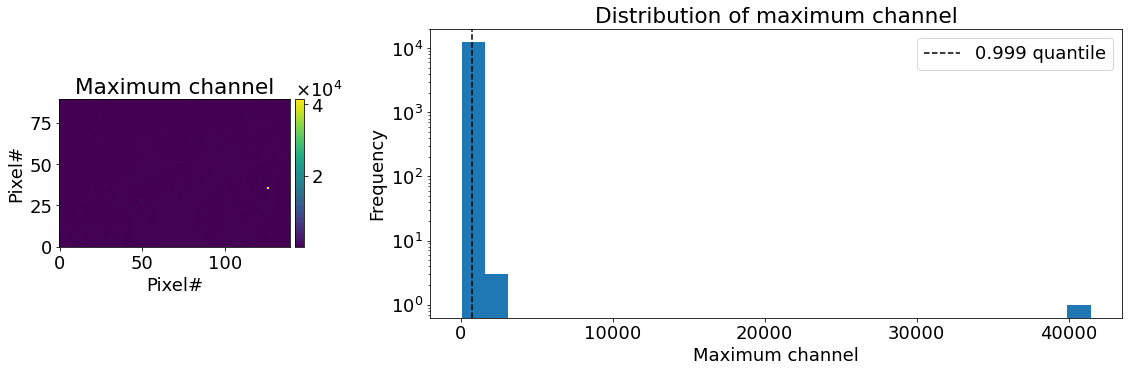

13 pixels out of 12600 are selected as burnt.


In [13]:
rcParams['font.size'] = 18

qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (16, 5), gridspec_kw={'width_ratios': [1, 3]})
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [14]:
data.correct_quantile_pixels(qtl)

13 pixels out of 12600 were corrected.


### Show aggregated information: integral, average and maximum

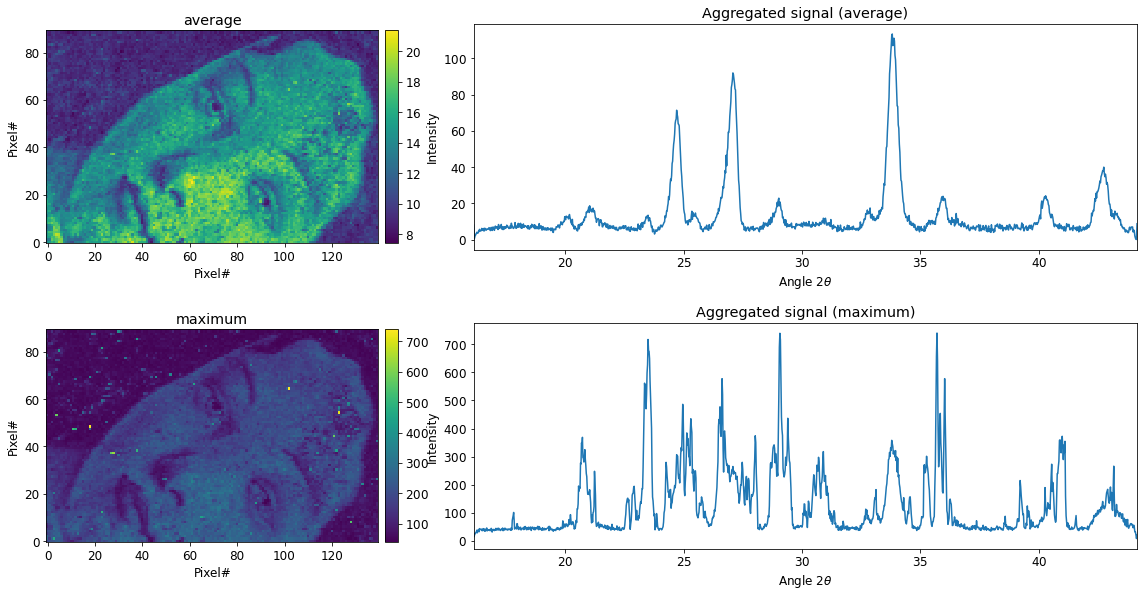

In [15]:
rcParams['font.size'] = 12

list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
list_i = [1, 2]

fig, axs = subplots(len(list_i), 2, figsize = (16, len(list_i) * 4), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

data_to_process = maximum(data.data - data.background, 0)
for j in range(len(list_i)):
    i = list_i[j]
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[j, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[j, 1]
    ax.plot(data.x, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(data.x[0], data.x[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

# Read XRF data

### Read XRF spectra

In [16]:
if path_xrf_spectra is not None:
    data_xrf_spectra = DataXRF().read(path_xrf_spectra).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_spectra)
    y_x_ratio = data_xrf_spectra.data.shape[0] / data_xrf_spectra.data.shape[1]
    print('\nShape of data\n-------------')
    print(f'x: {data_xrf_spectra.shape[1]}, y: {data_xrf_spectra.shape[0]}, channels: {data_xrf_spectra.shape[2]}')
    len_channels_xrf = data_xrf_spectra.shape[2]

Reading XRF data...
Done.

Shape of data
-------------
x: 140, y: 90, channels: 2048


### Read element maps
If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [17]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 18 images: images_Ba_L, images_Ca_K, images_Cd_L, images_Cl_K, images_Cr_K, images_Cu_Ka, images_Cu_Kb, images_Fe_K, images_Hg_L, images_K_K, images_Mn_K, images_P_K, images_Pb_L, images_Pb_M, images_S_K, images_Sr_K, images_Ti_K, images_Zn_K

Shape of XRF element maps
-------------------------
x: 140, y: 90


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [18]:
#qtl = 0.997

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

13 pixels out of 12600 were corrected on average in each XRF map.


# Choose elements and area

### View phases of chosen elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [19]:
elements_chosen = ['Pb']
elements_excluded = ['Ba', 'Co', 'Ni','Li']
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,(Pb O) (Pb (Cr O4)),Cr O5 Pb2,1
1,Anglesite,O4 Pb S,5
2,Cerussite,C O3 Pb,6
3,Crocoite,Cr O4 Pb,3
4,Hydrocerussite,C2 H2 O8 Pb3,2
5,Lead,Pb,5
6,Lead Chromate Oxide,Cr O5 Pb2,1
7,Lead-tin yellow,Pb2 Sn O4,1
8,Litharge,O Pb,12
9,Massicot,O Pb,1


### Select the area given by XRF threshold
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.

Element chosen for the map of XRF intensity: images_Pb_L
Threshold: 0.7
Selected pixels: 4793


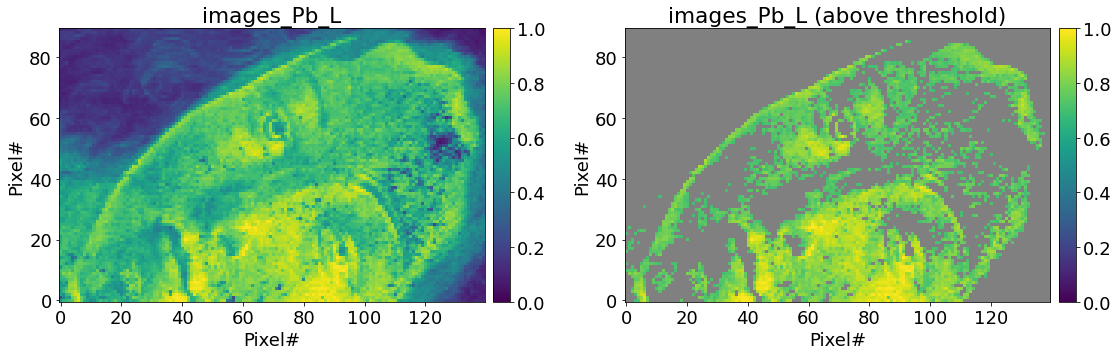

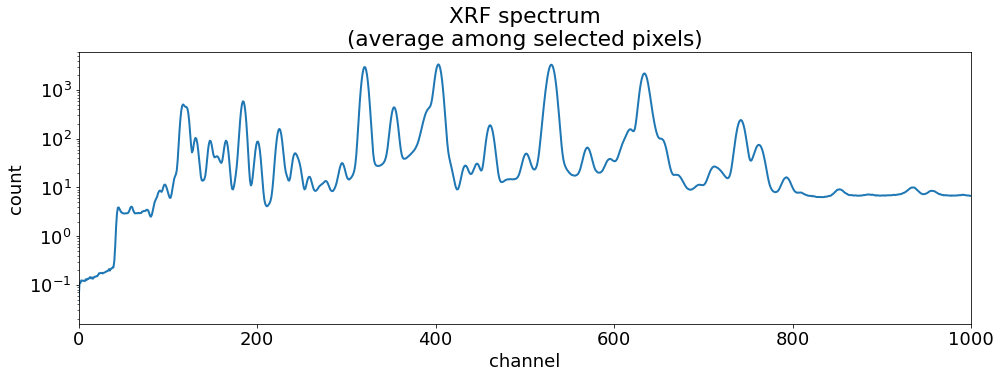

In [32]:
### Selection of area ###
threshold_XRF_intensity = 0.7

### Plots ###
rcParams['font.size'] = 18

### Plot of XRF spctrum ###
#limits_channel = [0, None]   # Default limits on channels
limits_channel = [0, 1000]   # Custom limits on channels
log_y_scale = True


###


idx_element = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf_elements.metadata['labels'][idx_element])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data_xrf_elements.labels.shape[:2], bool)
for x in range(data_xrf_elements.labels.shape[1]):
    for y in range(data_xrf_elements.labels.shape[0]):
        if maps_xrf_norm[y, x, idx_element] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

map_for_search = maps_xrf_norm[..., idx_element].copy()
map_for_search[~indices_XRF_sel] = nan

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none', vmin = 0, vmax = 1)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element])

ax = axs[1]
im = ax.imshow(map_for_search, interpolation = 'none', vmin = 0, vmax = 1, cmap = cmap_viridis)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element] + ' (above threshold)')

show()

if path_xrf_spectra is not None:
    indices_XRF_sel
    fig, ax = subplots(figsize = (16, 5))
    ax.plot(average(data_xrf_spectra.data[indices_XRF_sel], axis = 0), lw = 2)
    if log_y_scale:
        ax.set_yscale('log')
    ax.set_xlim(*limits_channel)
    ax.set_xlabel('channel')
    ax.set_ylabel('count')
    ax.set_title('XRF spectrum\n(average among selected pixels)')
    show()

In [22]:
data_xrf_spectra.data.shape

(90, 140, 2048)

In [24]:
average(data_xrf_spectra.data[indices_XRF_sel], axis = 0)

(2048,)

### In selected area, find the pixel of maximum XRF intensity of the first `elements_chosen`

In [15]:
quantile_xrf = 0.9   # Set to 1 to search for maximum, or to lowet values to search for the corresponding quantile.

threshold_qtl_xrf = nanquantile(map_for_search, quantile_xrf)
map_for_search_2 = map_for_search.copy()
map_for_search_2[map_for_search_2 > threshold_qtl_xrf] = nan
position = nanargmax(map_for_search_2)
y_xrf, x_xrf = unravel_index(position, map_for_search_2.shape)
print(f'Selected pixel: {(x_xrf, y_xrf)}')
print(f'Normalized XRF intensity: {map_for_search_2[y_xrf, x_xrf]:.3f}')

Selected pixel: (48, 1)
Normalized XRF intensity: 0.992


# Check a phase vs XRD pattern of the given pixel

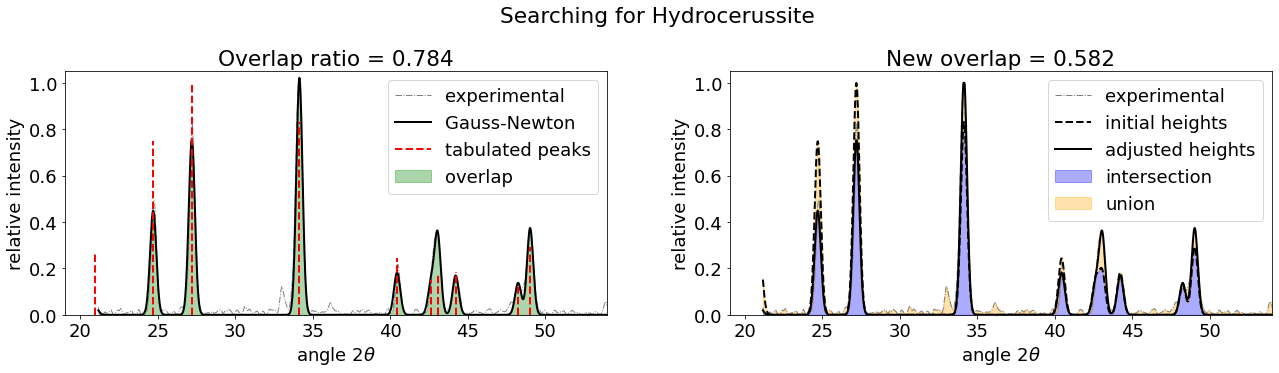

In [18]:
### Visualization options ###

rcParams['font.size'] = 18

#xrf_limits_channel = [0, len_channels_xrf]   # default limits
xrf_limits_channel = [0, 1000]              # custom limits
xrf_log_y = True


### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 10  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)


### Fit options ###

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Hydrocerussite'][0]

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = phase_check
#phase_calibration = database['Cuprorivaite'][0]


###

x, y = x_xrf, y_xrf

# XRF spectrum
if path_xrf_spectra is not None:
    fig, ax = subplots(figsize = (10, 5))
    ax.plot(data_xrf_spectra.data[y, x], lw = 2)
    if xrf_log_y:
        ax.set_yscale('log')
    ax.set_xlim(*xrf_limits_channel)
    ax.set_xlabel('channel')
    ax.set_ylabel('count')
    ax.set_title(f'XRF spectrum in {(x, y)}')
    show()

# XRD pattern
spectrum_xrd = (
    FastSpectraXRD()
    .from_Data(data, x, y)   
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)

### Pixel location and processing ###

### Fit ###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt.copy()

gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Measures of phase presence ###

fig, axs = subplots(1, 2, figsize = (18, 5))
fig.tight_layout(w_pad = 4)
fig.subplots_adjust(top = 0.8)   # To shift the title

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {presence:.3f}')

fig.suptitle(f'Searching for {gn.label}')

show()


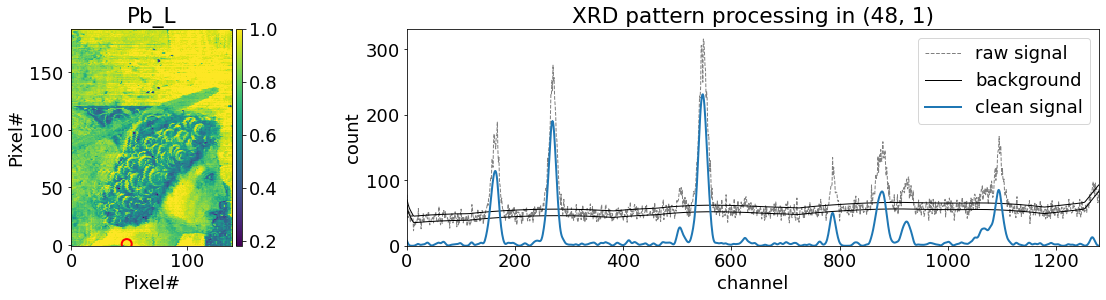

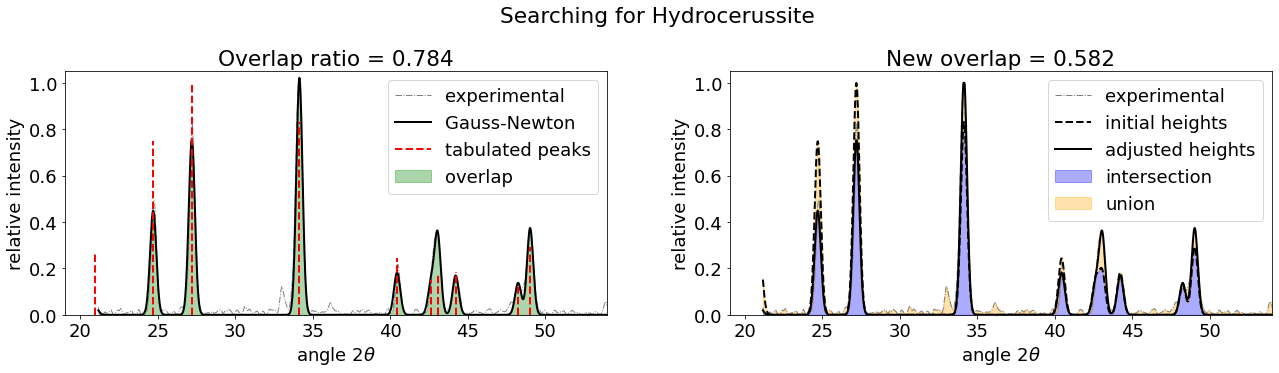

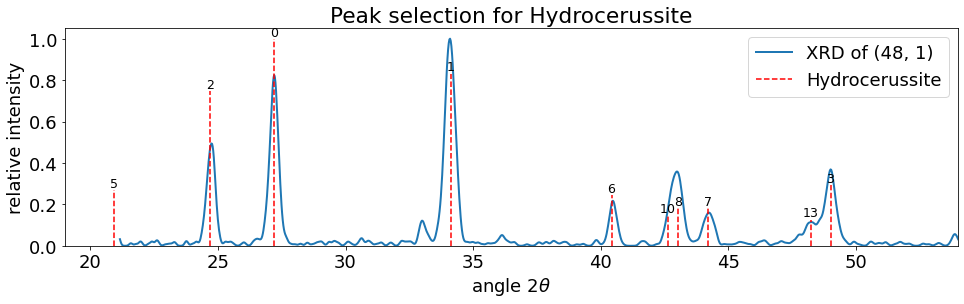

In [16]:
### Visualization options ###

rcParams['font.size'] = 18

#xrf_limits_channel = [0, len_channels_xrf]   # default limits
xrf_limits_channel = [0, 1000]              # custom limits
xrf_log_y = True


### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 10  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)


### Fit options ###

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Hydrocerussite'][0]

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = phase_check
#phase_calibration = database['Cuprorivaite'][0]


###

x, y = x_xrf, y_xrf

# XRF spectrum
if path_xrf_spectra is not None:
    fig, ax = subplots(figsize = (10, 5))
    ax.plot(data_xrf_spectra.data[y, x], lw = 2)
    if xrf_log_y:
        ax.set_yscale('log')
    ax.set_xlim(*xrf_limits_channel)
    ax.set_xlabel('channel')
    ax.set_ylabel('count')
    ax.set_title(f'XRF spectrum in {(x, y)}')
    show()

# XRD pattern
spectrum_xrd = (
    FastSpectraXRD()
    .from_Data(data, x, y)   
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)

### Pixel location and processing ###

fig, axs = subplots(1, 2, figsize = (16, 4), gridspec_kw={'width_ratios': [1, 3]})
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element])

ax = axs[1]
ax.plot(spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.background + spectrum_xrd.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(0, len(spectrum_xrd.counts))
ax.set_ylim(0, None)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title(f'XRD pattern processing in {(x, y)}')
show()

### Fit ###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 32).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt.copy()

gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Measures of phase presence ###

fig, axs = subplots(1, 2, figsize = (18, 5))
fig.tight_layout(w_pad = 4)
fig.subplots_adjust(top = 0.8)   # To shift the title

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {presence:.3f}')

fig.suptitle(f'Searching for {gn.label}')

show()

### Peak selection ###

fig, ax = subplots(figsize = (16, 4))
sca(ax)
ax.plot(gn.theta, gn.intensity, lw = 2, label = f'XRD of {(x, y)}')
gn.plot_phase(positions = True)
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Peak selection for {gn.label}')
show()

### Select peaks

In [17]:
#database['Cuprorivaite'][0].select_peaks([0, 1, 2, 3, 4, 5, 6, 7, 12, 27, 28])
database['Cuprorivaite'][0].select_peaks()
database['Copper silicate'][0].select_peaks()
None

# Reduce list of phases

### Smooth XRD data

In [18]:
### Smoothing options ###
window_snip = 32         # width of the window used for determining the background (default 32)
offset_background = 10   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 1          # degree of the final smooth applied to the XRD pattern (default 0)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...
Done.
Smoothing along channels...
Done.


### Fit selected phases on smoothed XRD pattern in selected area

In [19]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True)           # vecchio metodo
# ('overlap_area_ratio', False)    # vecchio metodo, altro modo di realizzarlo
# ('adjustment_ratio', False)      # nuovo metodo

adjust_calibration = False

###

list_presence = []
list_presence_avg = []
list_presence_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    print(f'Calculations for {phase_name} ({len(phase_set)})... ', end = '')
    gm = GammaMap().from_data(data, [p for p in phase_set], indices_XRF_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    if adjust_calibration:
        gm = gm.fit_cycle(gamma = True, steps = 10, verbose = False).fit_cycle(a = True, s = True, gamma = True, steps = 10, verbose = False)
    gm = gm.fit_cycle(gamma = True, steps = 10, verbose = False)
    presence = gm.format_as_1d_from_2d(gm.phase_presence(verbose = False, method = phase_presence_method, correction = phase_presence_correction))
    list_presence.append(presence)
    list_presence_avg.append(nanmean(presence, axis = 0))
    list_presence_max.append(nanmax(presence, axis = 0))
    list_x_y_sample = []
    for j in range(len(phase_set)):
        list_x_y_sample.append(gm.get_x_y(nanargmax(presence[:, j])))
    list_x_y.append(array(list_x_y_sample))
    
    print('Done.')

df_phases['Best avg presence'] = [nanmax(p) for p in list_presence_avg]
df_phases['Best max presence'] = [nanmax(p) for p in list_presence_max]

(df_phases
 .sort_values(by = ['Best avg presence'], ascending = False)
 .reset_index(drop = True)
 .style.format({'Best avg presence': '{:.3f}', 'Best max presence': '{:.3f}'}))

Calculations for Atacamite (2)... Done.
Calculations for Azurite_Natural_Fine (1)... Done.
Calculations for Botallackite (1)... Done.
Calculations for Ca Cu Si4 O10 (1)... Done.
Calculations for Clinoatacamite (3)... Done.
Calculations for Conichalcite (4)... Done.
Calculations for Copper (15)... Done.
Calculations for Copper silicate (1)... Done.
Calculations for Cu (7)... Done.
Calculations for Cuprite (6)... Done.
Calculations for Cuprorivaite (1)... Done.
Calculations for FluorescentPigmentBlue (1)... Done.
Calculations for Malachite (1)... Done.
Calculations for Paratacamite (4)... Done.
Calculations for Pseudomalachite (1)... Done.
Calculations for Tenorite (1)... Done.
Calculations for V Azurite_LeadTinYellow_2 (3)... Done.
Calculations for V Basic copper calcium carbonate (2)... Done.
Calculations for V Basic copper carbonate (2)... Done.
Calculations for V Copper Hydroxyde carbonate (2)... Done.
Calculations for V Copper hydroxide carbonate (4)... Done.
Calculations for V CuSi

,Name in database,Chemical formula,N. of samples,Best avg presence,Best max presence
0,Ca Cu Si4 O10,Ca Cu O10 Si4,1,0.154,0.386
1,Cuprorivaite,Ca Cu O10 Si4,1,0.151,0.354
2,Copper silicate,Ca Cu Si4 O10,1,0.150,0.337
3,V Azurite_LeadTinYellow_2,Cu C O H Pb Sn,3,0.121,0.242
4,V CuSiO3,Cu Si O3,1,0.120,0.314
5,V Copper Hydroxyde carbonate,Cu C O H,2,0.120,0.249
6,V sodium calcium aluminium silicate Copper Hydroxide Carbonate,Na Ca Al Si O S Cl Cu H,2,0.115,0.276
7,Malachite,C H2 Cu2 O5,1,0.109,0.201
8,V Copper hydroxide carbonate,Cu3 C2 O8 H2,4,0.089,0.222
9,Conichalcite,As Ca Cu H O5,4,0.081,0.195


### Select phase samples as primary or secondary phases

##### How thresholds are used
- `thresholds_presence_avg`. If avg presence of a phase is above the second threshold, the phase can be selected as primary. Otherwise, if avg presence is above the first threshold, the phase can be selected as secondary.
- `factor_quantile` ($f$). Let $q_1$ and $q_3$ be the first and third quantiles of the population of presence values of a given phase sample in the selected pixels. If the maximum presence is above $q_3 + f (q_3 - q_1)$, the phase sample is discarded for having outlier presence values.

##### Note
If a phase is selected as primary, it is prevented from being selected as secondary, even with a different sample.

In [20]:
thresholds_presence_avg = [0.10, 0.15]
factor_quantile = 3 # the higher, the more permissive the filter is with respect to outliers


def outlier_threshold(population, factor = 1.5):
    q1 = quantile(population, 0.25)
    q3 = quantile(population, 0.75)
    return q3 + factor * (q3 - q1)


list_sel_category = []
list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_presence_avg = []
list_sel_presence_max = []
list_sel_x_y_presence_max = []

for i in range(df_phases.shape[0]):
    arr_outlier_threshold = array([outlier_threshold(list_presence[i][:, j], factor_quantile) for j in range(df_phases.loc[i, 'N. of samples'])])
    idx = (list_presence_avg[i] >= thresholds_presence_avg[1]) & (list_presence_max[i] <= arr_outlier_threshold)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_presence_avg_filtered = list_presence_avg[i][idx]
        arr_presence_max_filtered = list_presence_max[i][idx]
        arr_x_y_filtered = list_x_y[i][idx]
        j = nanargmax(arr_presence_avg_filtered)
        
        list_sel_category.append('Primary')
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_presence_avg.append(arr_presence_avg_filtered[j])
        list_sel_presence_max.append(arr_presence_max_filtered[j])
        list_sel_x_y_presence_max.append(tuple(arr_x_y_filtered[j]))
    else:
        idx = (list_presence_avg[i] >= thresholds_presence_avg[0]) & (list_presence_max[i] <= arr_outlier_threshold)
        if any(idx):
            arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
            arr_presence_avg_filtered = list_presence_avg[i][idx]
            arr_presence_max_filtered = list_presence_max[i][idx]
            arr_x_y_filtered = list_x_y[i][idx]
            j = nanargmax(arr_presence_avg_filtered)

            list_sel_category.append('Secondary')
            list_sel_name.append(df_phases.loc[i, 'Name in database'])
            list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
            list_sel_sample.append(arr_sample_filtered[j])
            list_sel_presence_avg.append(arr_presence_avg_filtered[j])
            list_sel_presence_max.append(arr_presence_max_filtered[j])
            list_sel_x_y_presence_max.append(tuple(arr_x_y_filtered[j]))

df_phases_sel = DataFrame({
    'Category': list_sel_category,
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Presence avg': list_sel_presence_avg,
    'Presence max': list_sel_presence_max,
    '(x, y) presence max': list_sel_x_y_presence_max
})
df_phases_sel = df_phases_sel.sort_values(by = ['Presence avg'], ascending = False).reset_index(drop = True)
df_phases_sel.style.format({'Presence avg': '{:.3f}', 'Presence max': '{:.3f}'})

,Category,Phase,Formula,Sample,Presence avg,Presence max,"(x, y) presence max"
0,Primary,Ca Cu Si4 O10,Ca Cu O10 Si4,0,0.154,0.386,"(31, 1)"
1,Primary,Cuprorivaite,Ca Cu O10 Si4,0,0.151,0.354,"(20, 14)"
2,Primary,Copper silicate,Ca Cu Si4 O10,0,0.150,0.337,"(27, 3)"
3,Secondary,V Azurite_LeadTinYellow_2,Cu C O H Pb Sn,0,0.121,0.242,"(23, 1)"
4,Secondary,V CuSiO3,Cu Si O3,0,0.120,0.314,"(22, 3)"
5,Secondary,V Copper Hydroxyde carbonate,Cu C O H,1,0.120,0.249,"(19, 11)"
6,Secondary,V sodium calcium aluminium silicate Copper Hydroxide Carbonate,Na Ca Al Si O S Cl Cu H,0,0.115,0.276,"(29, 4)"
7,Secondary,Malachite,C H2 Cu2 O5,0,0.109,0.201,"(23, 20)"


# Check the fit of listed phases

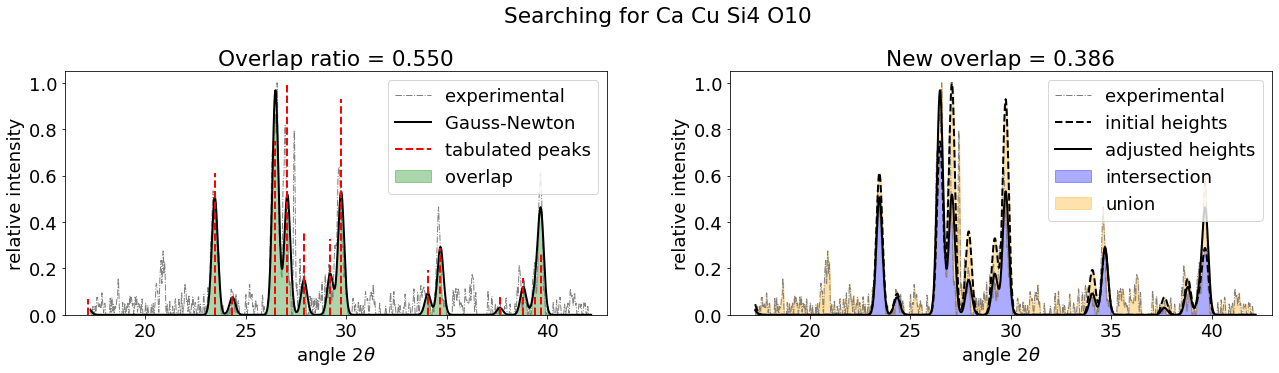

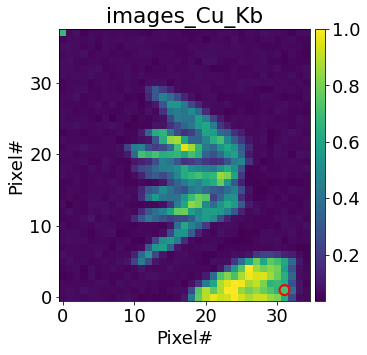

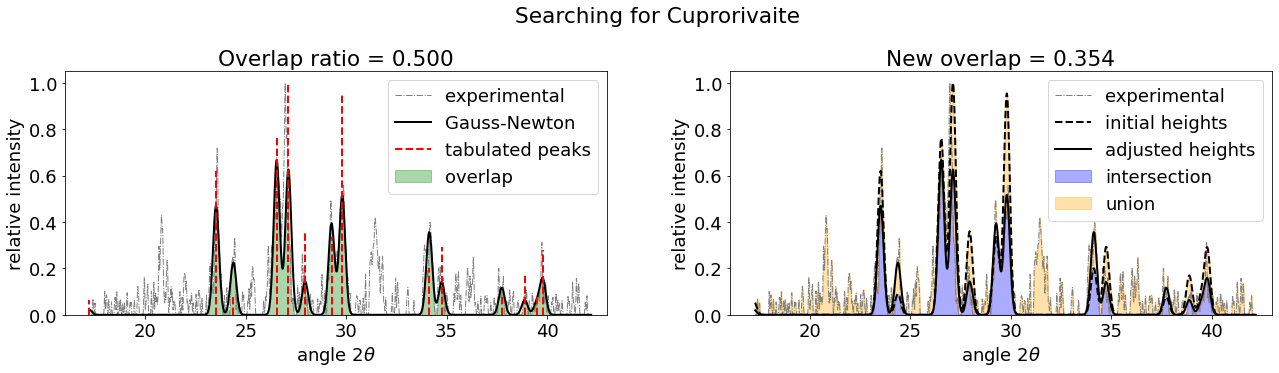

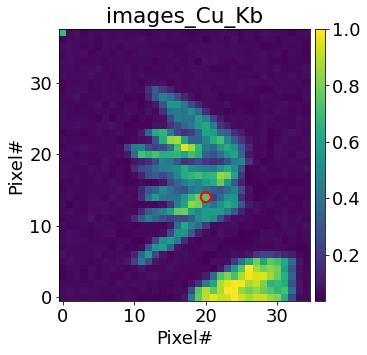

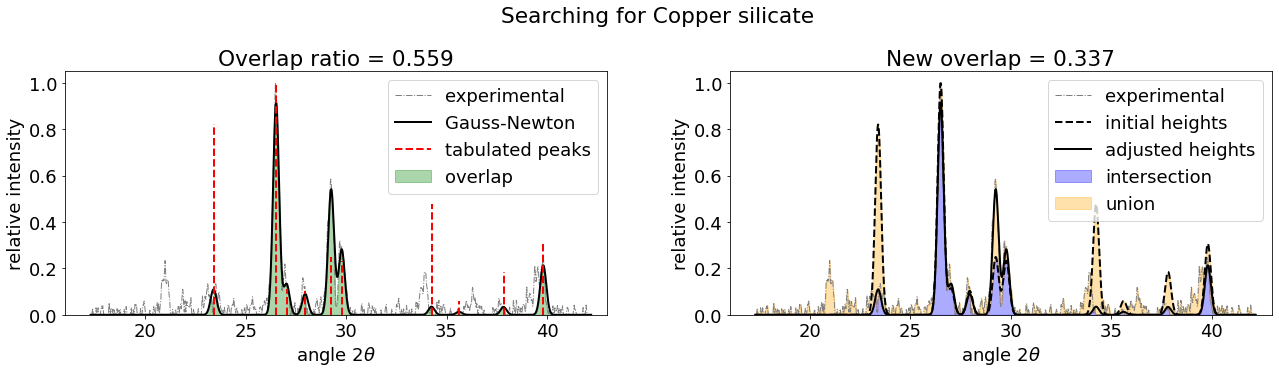

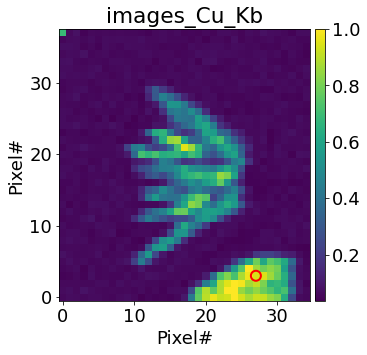

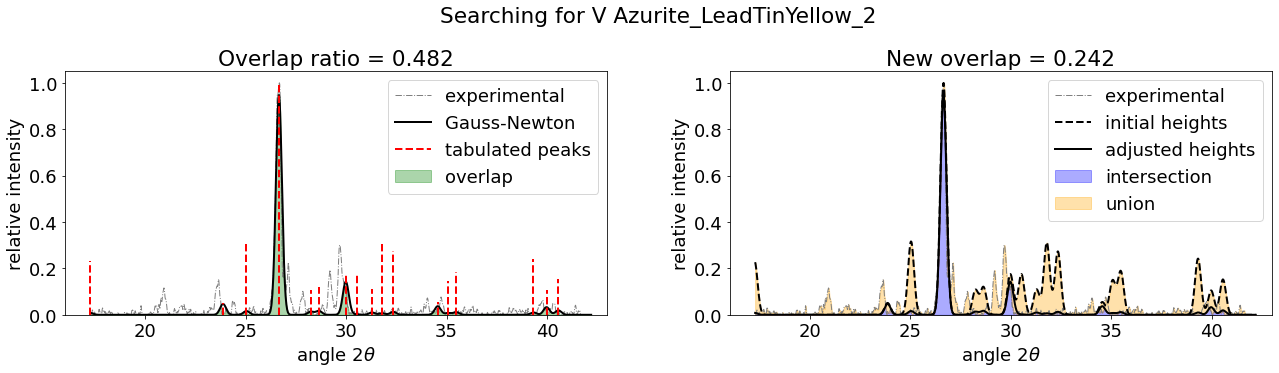

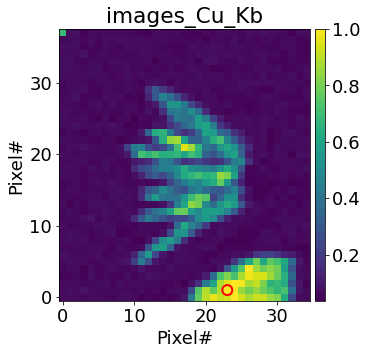

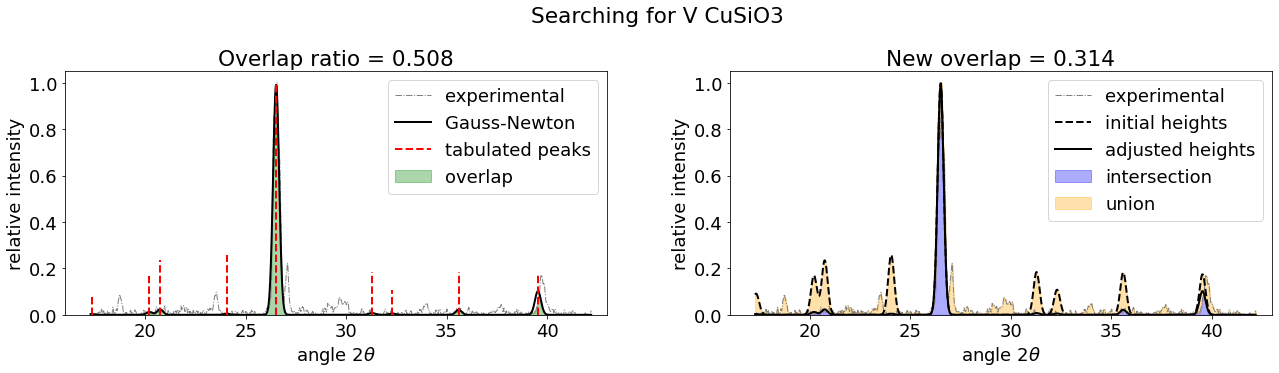

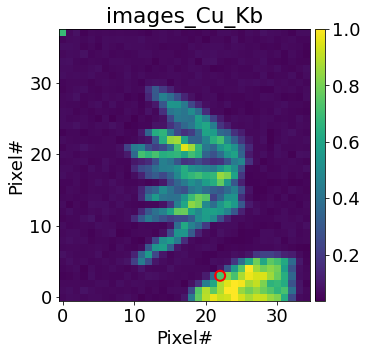

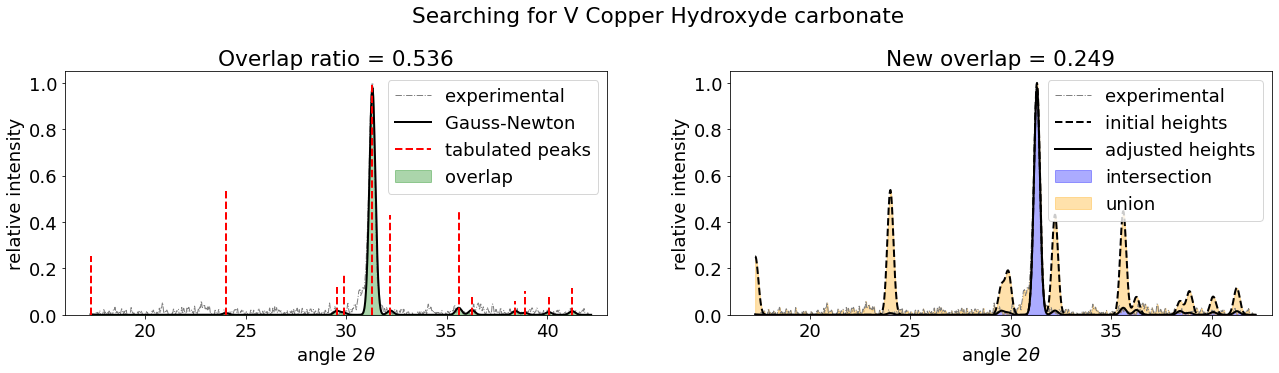

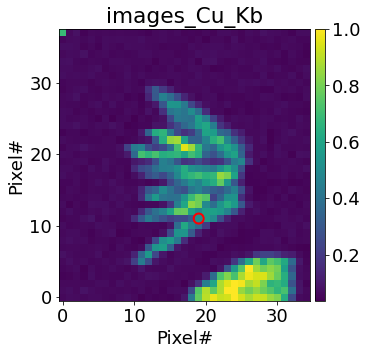

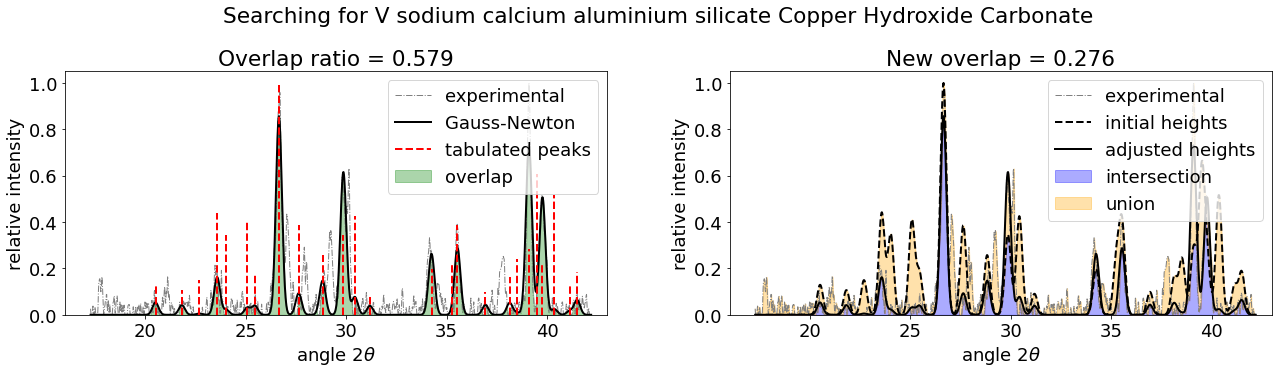

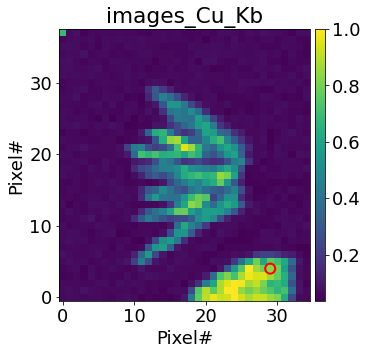

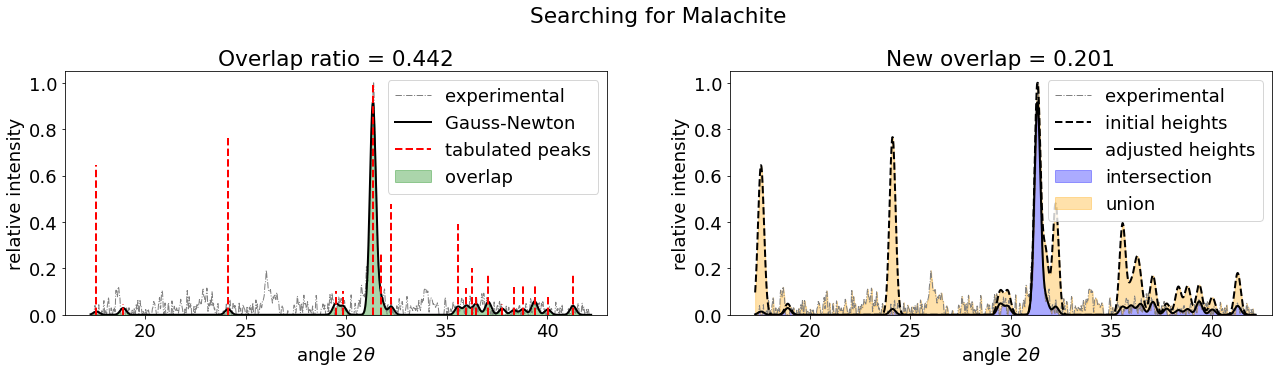

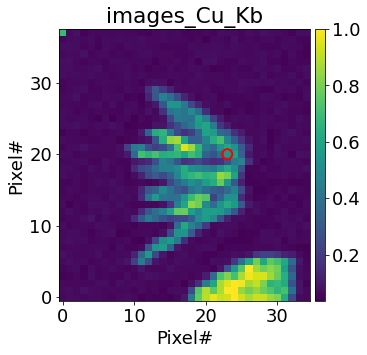

In [21]:
### Visualization options ###

rcParams['font.size'] = 18

#xrf_limits_channel = [0, len_channels_xrf]   # default limits
#xrf_limits_channel = [0, 1000]               # custom limits
#xrf_log_y = True


### Fit options ###

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = False
#phase_calibration = database['Jarosite'][15]
phase_calibration = None


###

### Calculations and plots ###

for i in range(df_phases_sel.shape[0]):
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    x, y = df_phases_sel.loc[i, '(x, y) presence max']
    phase_check = database[phase_name][phase_sample]

    gn = GaussNewton(phase_check, FastSpectraXRD().from_Data(data, x, y), sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    
    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, FastSpectraXRD().from_Data(data, x, y), sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt.copy()
        
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd_{x}_{y}_calibrated_with_{clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
    
    gn.fit_cycle(gamma = True, steps = 16)
    
    ### Save experimental phase ###
    phase_exp = gn.make_phase()
    filename = path_database_exp + clean_phase_name(gn.label) + '.cif'
    phase_exp.save_cif(filename)
    
    z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
    z = clip(gn.z(), None, 1)
    intensity_corrected = maximum(gn.intensity, 0)
    z_stack = stack((z0, z, intensity_corrected))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    presence = z_min.sum() / z_max.sum()

    ### Plot fit ###

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title

    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {presence:.3f}')

    fig.suptitle(f'Searching for {gn.label}')

    savefig(f'{path_phases_check}{clean_phase_name(gn.label)} {x}_{y} check_fit.png', bbox_inches = 'tight', dpi = 300)
    show()

    # Map of element
    fig, ax = subplots(figsize = (5, 5))
    im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
    #ax.scatter(x, y, s = 500, c = 'red', marker = '+')
    ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    ax.set_title(data_xrf_elements.metadata['labels'][idx_element])
    show()
    
    # XRF spectrum
    if path_xrf_spectra is not None:
        fig, ax = subplots(figsize = (16, 5))
        ax.plot(data_xrf_spectra.data[y, x], lw = 2)
        if xrf_log_y:
            ax.set_yscale('log')
        ax.set_xlim(*xrf_limits_channel)
        ax.set_xlabel('channel')
        ax.set_ylabel('count')
        ax.set_title(f'XRF spectrum in {(x, y)}')
        show()

# Select phases and save list

### Review list of phases

In [22]:
df_phases_sel.style.format({'Presence avg': '{:.3f}', 'Presence max': '{:.3f}'})

,Category,Phase,Formula,Sample,Presence avg,Presence max,"(x, y) presence max"
0,Primary,Ca Cu Si4 O10,Ca Cu O10 Si4,0,0.154,0.386,"(31, 1)"
1,Primary,Cuprorivaite,Ca Cu O10 Si4,0,0.151,0.354,"(20, 14)"
2,Primary,Copper silicate,Ca Cu Si4 O10,0,0.150,0.337,"(27, 3)"
3,Secondary,V Azurite_LeadTinYellow_2,Cu C O H Pb Sn,0,0.121,0.242,"(23, 1)"
4,Secondary,V CuSiO3,Cu Si O3,0,0.120,0.314,"(22, 3)"
5,Secondary,V Copper Hydroxyde carbonate,Cu C O H,1,0.120,0.249,"(19, 11)"
6,Secondary,V sodium calcium aluminium silicate Copper Hydroxide Carbonate,Na Ca Al Si O S Cl Cu H,0,0.115,0.276,"(29, 4)"
7,Secondary,Malachite,C H2 Cu2 O5,0,0.109,0.201,"(23, 20)"


### Select phases to write in file
Leave empty list to select all phases.

In [23]:
list_names_phase = ['Cuprorivaite', 'Copper silicate']
#list_names_phase = []   # leave empty list to select all phases

### Delete the files with list of selected phases
Delete the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`.

In [24]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for file_name in ['phases_selection_primary.dat', 'phases_selection_secondary.dat']:
        if exists(subfolder_output + file_name):
            remove(subfolder_output + file_name)

### Add selected phases to their appropriate file

This cell writes the list of names of selected phases into the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`. If the files do not exist, the cell creates them.

In [25]:
if len(list_names_phase) > 0:
    df_phases_sel_2 = df_phases_sel[df_phases_sel['Phase'].isin(list_names_phase)]
else:
    df_phases_sel_2 = df_phases_sel

for category in ['Primary', 'Secondary']:
    filename = f'{subfolder_output}phases_selection_{category.lower()}.dat'
    (df_phases_sel_2
     .loc[df_phases_sel['Category'] == category, ['Phase', 'Formula', 'Sample', 'Presence avg', 'Presence max']]
     .to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f'))